In [1]:
import pandas as pd

In [2]:
X_train = pd.read_csv('X_train_w_ID.csv', index_col=0)
X_test = pd.read_csv('X_test_w_ID.csv', index_col = 0)
Y_train = pd.read_csv('Y_train.csv', index_col = 0, header= None, names = ['Y'])
Y_test = pd.read_csv('Y_test.csv', index_col = 0, header= None, names = ['Y'])

In [4]:
x_train = X_train.drop("DESYNPUF_ID",axis=1)

In [7]:
x_test = X_test.drop('DESYNPUF_ID',axis=1)

In [10]:
Y_train.head()

,Y
108760,0
2466,0
65436,0
58670,0
99259,0


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#We'll build a RF and compare to a DT
clf_def = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 20)
clf_def = clf_def.fit(x_train, Y_train)
dt_pred = clf_def.predict_proba(x_test)

rf_def = RandomForestClassifier(criterion='entropy', n_estimators=100)
rf_def = rf_def.fit(x_train, Y_train)
rf_pred = rf_def.predict_proba(x_test)


/Users/ksenia/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


In [17]:
dt_pred[:,1]

array([ 0.,  1.,  0., ...,  0.,  0.,  0.])

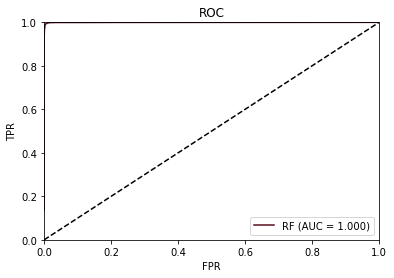

In [21]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

plotUnivariateROC(rf_pred[:,1], Y_test, 'RF')
plt.show()

In [13]:

#define a function to print ROC curves. 
#It should take in only arrays/lists of predictions and outcomes
from sklearn.metrics import roc_curve, auc

def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #Student input code here
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc